> # Data Load, Preprocessing

There is dataset concept in data API. This means continous data samples. It usually uses dataset that is read in disk. But we can generate dataset in memory by keras.

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

**from_tensor_slices** function makes **tf.data.Dataset** expressed each variable of **X** to item. This dataset has 10 items. And It is same with **tf.data.Dataset.range(10)**

In [3]:
for i in dataset:
    print(i)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


### - Chain conversion

We can do variance conversions by calling transform method.

In [4]:
dataset = dataset.repeat(3).batch(7)
for i in dataset:
    print(i)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


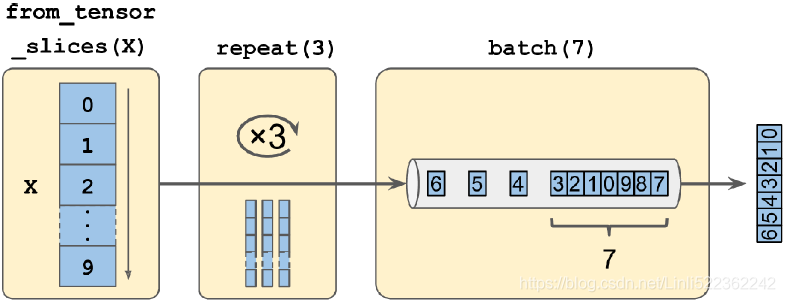

If we call **drop_remainder=True** in **batch()** method it sets all batch to same scale. So last batch is removed.

We can converse item just calling **map()** method. This method can be transformed to tensorflow function.

In [5]:
dataset = dataset.map(lambda x: x*2)

## [0, 2, 4, 6, 8, 10, 12]...

**map()** method applies conversion to each item. But **apply()** method applied to all dataset.

In [6]:
dataset = dataset.apply(tf.data.experimental.unbatch())

Instructions for updating:
Use `tf.data.Dataset.unbatch()`.


Each item in dataset is not batch a integer tensor.

And do filtering dataset using **filter()** method.

In [7]:
dataset = dataset.filter(lambda x : x < 10)

Sometimes we want to see some items. Then use **take()** method.

In [8]:
for i in dataset.take(3):
    print(i)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


### - Data Shuffling

To maximize performance of gradient descent, shuffle samples using **shuffle()** method. First, this method samples items of raw dataset as **buffer_size** number. Then if user requires new item, it randomly returns a new item from this buffer. And fills cleared buffer by sampling new items from raw dataset. This is repeated until all items in raw dataset are used. To use this method, setting buffer size is important. And setting buffer size big enough is also important. But it should not exceed memory size. And although we have enough memory, buffer size don't have to exceed dataset size.

In [9]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=5, seed=10,).batch(7)

for i in dataset:
    print(i)

tf.Tensor([0 5 2 3 6 8 1], shape=(7,), dtype=int64)
tf.Tensor([4 9 3 2 4 0 5], shape=(7,), dtype=int64)
tf.Tensor([8 1 7 1 6 2 3], shape=(7,), dtype=int64)
tf.Tensor([7 9 4 8 9 0 6], shape=(7,), dtype=int64)
tf.Tensor([7 5], shape=(2,), dtype=int64)


Simple shuffling buffer method is not enough for huge dataset bigger than memory size. A solution is to shuffle raw dataset. Then shuffling affection increase much better. In this case, we usually shuffles one more at each epoch although raw dataset is shuffled. If we don't do this progress, same order is repeated so bias added to model.

One way to more shuffle samples is deviding raw data to some flies and randomly read it during training. But sample in same file is processed together. To avoid it, we can randomly choose several files and take turns returning records read from file at same time.

For example, we use California housing data. Split it train, validation, and test set. And scaling is apllied.

In [16]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

In [19]:
import numpy as np
import os

def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths


train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

Each set is devided 20 or 10 csv files. And **train_filepaths** is a list of route for train file.

In [20]:
train_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

In [21]:
filepaths_dataset = tf.data.Dataset.list_files(train_filepaths, seed=3)

**list_file** function returns dataset which shuffled file route. Then call **interleave()** method and read 5 files one lines at a time.

In [22]:
n_readers = 5
dataset = filepaths_dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
                                      cycle_length=n_readers)

**interleave** method makes a dataset which reads data from 5 file route in **filepath_dataset**. It will make new data set by calling labda function to each file.

In [24]:
for line in dataset.take(5):
    print(line.numpy())

b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67'
b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'
b'8.72,44.0,6.163179916317992,1.0460251046025104,668.0,2.794979079497908,34.2,-118.18,4.159'
b'5.9522,26.0,6.196521739130435,1.0069565217391305,1479.0,2.5721739130434784,34.5,-119.75,4.384'
b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205'


And make data preprocess function.

In [25]:
n_inputs = 8

def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [26]:
preprocess(b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.19852655,  1.2954322 , -0.13117608, -0.31340504, -0.8508079 ,
        -0.04867317,  0.85898864, -1.3022108 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.67], dtype=float32)>)

And we make a function that loads california dataset and applies preprocessing, shuffling, repeat and batch.

In [31]:
def csv_reader_dataset(filepath, repeat=1, n_reader=5, n_read_thread=None, shuffle_buffer_size=10000,
                      n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepath).repeat(repeat)
    dataset = dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
                                 cycle_length=n_readers, num_parallel_calls=n_read_thread)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

Last **prefetch** method makes dataset be ready a batch. Training algorithm prepares next batch during one batch is running.

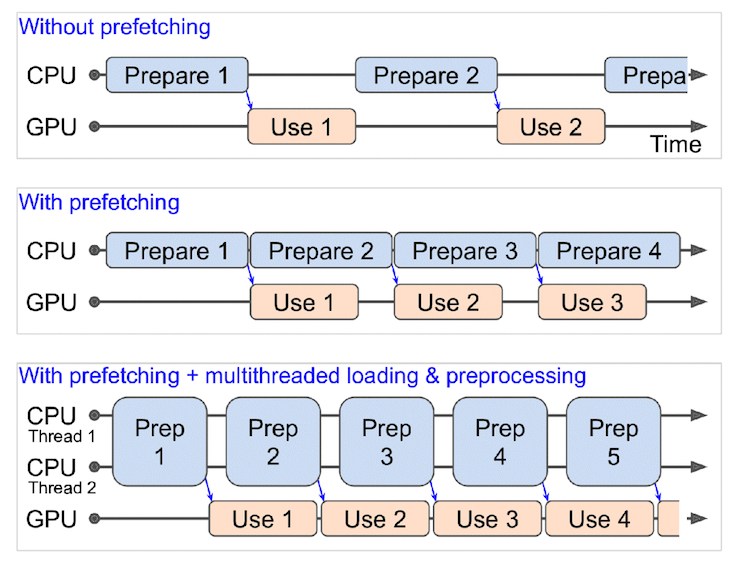

We can make dataset to use train set using **csv_reader_dataset()**. We don't have to set repeat.

In [32]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

Just send it to model and train, evaluate model!